# ⏰ Time Travel Demo - Apache Iceberg

## Credit Card Fraud Detection - IEEE-CIS Dataset

**Yêu cầu đề bài:** 
> "Yêu cầu tính năng Time Travel của Iceberg để truy vấn lại trạng thái dữ liệu tại thời điểm quá khứ nhằm kiểm tra lại các giao dịch nghi vấn."

**Mục tiêu:**
- Demo tính năng Time Travel của Apache Iceberg
- Truy vấn dữ liệu tại các snapshot khác nhau
- Kiểm tra lại trạng thái giao dịch nghi vấn tại thời điểm quá khứ
- Rollback dữ liệu về version trước nếu cần

---
### ⚠️ Lưu ý quan trọng

**Notebook này hoạt động SAU KHI đã chạy pipeline đầy đủ:**
- Chạy từ **Script Full**: `./scripts/run_full_pipeline.sh`
- Kiến trúc Medallion: `demo.bronze.*`, `demo.silver.*`, `demo.gold.*`

**Tên bảng và cột (từ dbt):**
- Bảng: `demo.silver.silver_transactions`
- Các cột: `is_fraud`, `transaction_amount`, `TransactionID`, `transaction_hour`, `card_brand`

## 1. Khởi tạo Spark Session

In [116]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from datetime import datetime

# Khởi tạo Spark Session
spark = SparkSession.builder \
    .appName("Time Travel Demo - Fraud Detection") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.demo", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.demo.type", "rest") \
    .config("spark.sql.catalog.demo.uri", "http://iceberg-rest:8181") \
    .config("spark.sql.catalog.demo.io-impl", "org.apache.iceberg.aws.s3.S3FileIO") \
    .config("spark.sql.catalog.demo.warehouse", "s3://warehouse/") \
    .config("spark.sql.catalog.demo.s3.endpoint", "http://minio:9000") \
    .config("spark.sql.catalog.demo.s3.path-style-access", "true") \
    .config("spark.sql.catalog.demo.s3.access-key-id", "admin") \
    .config("spark.sql.catalog.demo.s3.secret-access-key", "password123") \
    .config("spark.sql.defaultCatalog", "demo") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "admin") \
    .config("spark.hadoop.fs.s3a.secret.key", "password123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

print("✅ Spark Session đã khởi tạo!")

✅ Spark Session đã khởi tạo!


## 2. Xem lịch sử Snapshots của bảng

Iceberg lưu trữ mỗi thay đổi dữ liệu như một "snapshot". Ta có thể xem lịch sử các snapshots để biết các thời điểm có thể truy vấn.

In [117]:
# Xem lịch sử snapshots của bảng silver_transactions (từ dbt)
# Kiến trúc Medallion: bronze, silver, gold riêng biệt
TABLE_NAME = "demo.silver.silver_transactions"

print(f"📜 Lịch sử Snapshots - {TABLE_NAME}:")
print("=" * 80)

df_snapshots = spark.sql(f"""
    SELECT 
        snapshot_id,
        committed_at,
        operation,
        summary
    FROM {TABLE_NAME}.snapshots
    ORDER BY committed_at DESC
""")

df_snapshots.show(truncate=False)

# Lưu vào biến snapshots để dùng cho visualization
snapshots = df_snapshots.collect()
print(f"\n📊 Tổng số snapshots: {len(snapshots)}")

📜 Lịch sử Snapshots - demo.silver.silver_transactions:
+-------------------+-----------------------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|snapshot_id        |committed_at           |operation|summary                                                                                                                                                                                                                                                                           

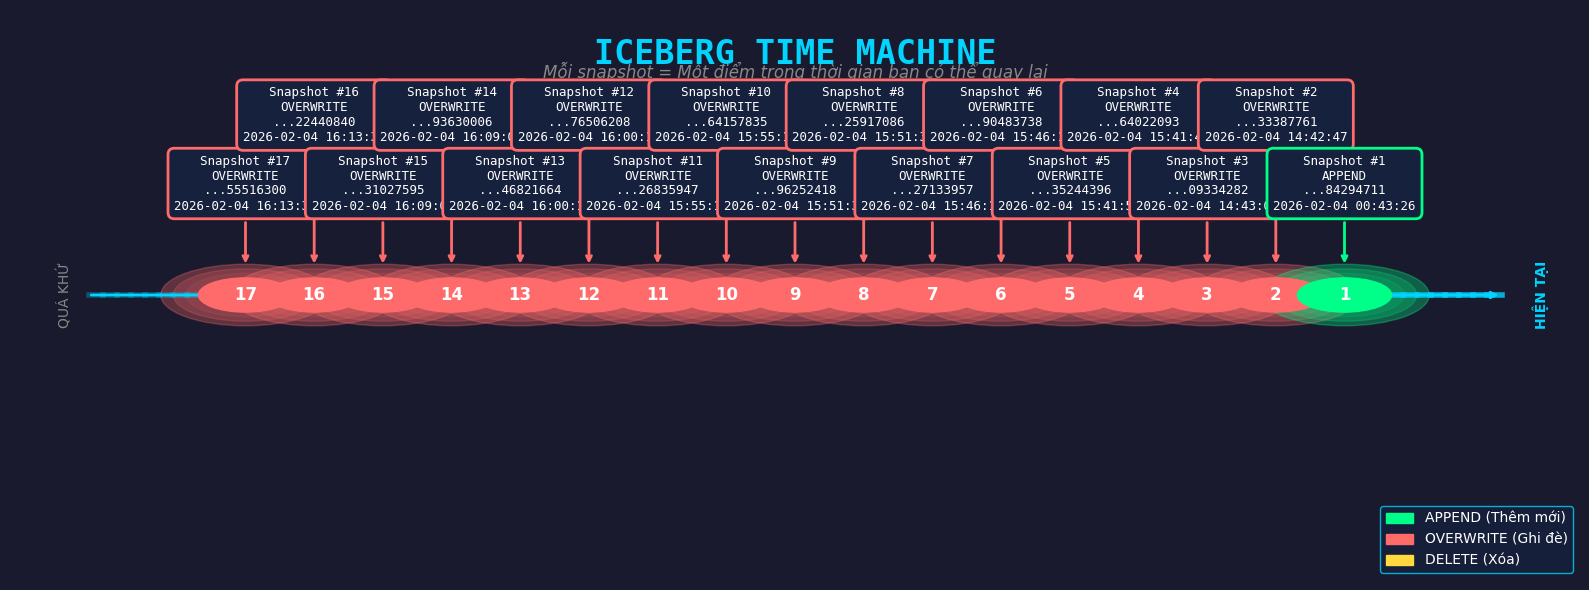


Tổng số điểm thời gian có thể truy cập: 17
   -> Bạn có thể 'du hành' đến bất kỳ snapshot nào trong timeline!


In [118]:
# VISUALIZATION: Snapshot Timeline - Time Machine Effect (no emoji)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

fig, ax = plt.subplots(figsize=(16, 6))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#1a1a2e')

# Title with glow effect
ax.text(0.5, 0.95, 'ICEBERG TIME MACHINE', transform=ax.transAxes,
        fontsize=24, fontweight='bold', ha='center', va='top',
        color='#00d4ff', family='monospace')
ax.text(0.5, 0.88, 'Mỗi snapshot = Một điểm trong thời gian bạn có thể quay lại',
        transform=ax.transAxes, fontsize=12, ha='center', color='#888888', style='italic')

# Draw timeline
n_snapshots = len(snapshots)
timeline_y = 0.5

# Timeline base line with gradient effect
for i in range(100):
    alpha = 0.3 + 0.5 * (i / 100)
    ax.plot([0.05 + i*0.009, 0.05 + (i+1)*0.009], [timeline_y, timeline_y], 
            color='#00d4ff', linewidth=4, alpha=alpha)

# Snapshot points
x_positions = np.linspace(0.15, 0.85, n_snapshots) if n_snapshots > 1 else [0.5]
operations = [row['operation'] for row in snapshots]
snapshot_ids = [str(row['snapshot_id'])[-8:] for row in snapshots]
timestamps = [str(row['committed_at'])[:19] for row in snapshots]

# Colors for operations
op_colors = {'append': '#00ff88', 'overwrite': '#ff6b6b', 'delete': '#ffd93d'}

for i, (x, op, snap_id, ts) in enumerate(zip(x_positions, operations, snapshot_ids, timestamps)):
    color = op_colors.get(op, '#00d4ff')
    
    # Glow effect
    for glow in range(3, 0, -1):
        circle = plt.Circle((x, timeline_y), 0.03 + glow*0.008, 
                           color=color, alpha=0.1*glow, transform=ax.transAxes)
        ax.add_patch(circle)
    
    # Main point
    circle = plt.Circle((x, timeline_y), 0.03, color=color, 
                        transform=ax.transAxes, zorder=10)
    ax.add_patch(circle)
    
    # Snapshot number
    ax.text(x, timeline_y, f'{n_snapshots - i}', transform=ax.transAxes,
            fontsize=12, ha='center', va='center', color='white', fontweight='bold', zorder=11)
    
    # Info box above (plain text)
    box_y = timeline_y + 0.15 + (i % 2) * 0.12  # Stagger boxes
    ax.annotate(f'Snapshot #{n_snapshots - i}\n{op.upper()}\n...{snap_id}\n{ts}',
                xy=(x, timeline_y + 0.05), xytext=(x, box_y),
                transform=ax.transAxes, fontsize=9, ha='center',
                color='white', family='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#16213e', 
                         edgecolor=color, linewidth=2),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))

# Legend
legend_items = [
    mpatches.Patch(color='#00ff88', label='APPEND (Thêm mới)'),
    mpatches.Patch(color='#ff6b6b', label='OVERWRITE (Ghi đè)'),
    mpatches.Patch(color='#ffd93d', label='DELETE (Xóa)')
]
ax.legend(handles=legend_items, loc='lower right', facecolor='#16213e', 
          edgecolor='#00d4ff', labelcolor='white', fontsize=10)

# Time arrow
ax.annotate('', xy=(0.95, timeline_y), xytext=(0.05, timeline_y),
            transform=ax.transAxes,
            arrowprops=dict(arrowstyle='->', color='#00d4ff', lw=2))
ax.text(0.03, timeline_y, 'QUÁ KHỨ', transform=ax.transAxes, 
        fontsize=10, color='#888888', va='center', rotation=90)
ax.text(0.97, timeline_y, 'HIỆN TẠI', transform=ax.transAxes,
        fontsize=10, color='#00d4ff', va='center', rotation=90, fontweight='bold')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nTổng số điểm thời gian có thể truy cập: {len(snapshots)}")
print("   -> Bạn có thể 'du hành' đến bất kỳ snapshot nào trong timeline!")

In [119]:
# Xem chi tiết History với thông tin thêm
print(f"📜 Table History - {TABLE_NAME}:")
spark.sql(f"""
    SELECT 
        made_current_at,
        snapshot_id,
        is_current_ancestor
    FROM {TABLE_NAME}.history
    ORDER BY made_current_at
""").show(truncate=False)

📜 Table History - demo.silver.silver_transactions:
+-----------------------+-------------------+-------------------+
|made_current_at        |snapshot_id        |is_current_ancestor|
+-----------------------+-------------------+-------------------+
|2026-02-04 00:43:26.049|1976471298584294711|true               |
|2026-02-04 14:42:47.303|7747718758633387761|true               |
|2026-02-04 14:43:05.52 |5180983341009334282|true               |
|2026-02-04 15:41:45.502|7534372502964022093|true               |
|2026-02-04 15:41:50.804|7758794509335244396|true               |
|2026-02-04 15:46:10.677|1806896470890483738|true               |
|2026-02-04 15:46:12.498|6404433262427133957|true               |
|2026-02-04 15:51:34.07 |6660724509825917086|true               |
|2026-02-04 15:51:35.226|7227363647896252418|true               |
|2026-02-04 15:55:17.104|2833092130164157835|true               |
|2026-02-04 15:55:18.675|3652438488726835947|true               |
|2026-02-04 16:00:17.254|

## 3. Tạo thêm snapshots để demo Time Travel

Để demo Time Travel, ta sẽ tạo thêm một số thay đổi để có nhiều snapshots.

In [120]:
# Đếm số fraud hiện tại
# Lưu ý: dbt đã đổi tên cột isFraud -> is_fraud
current_fraud_count = spark.sql(f"""
    SELECT COUNT(*) as cnt FROM {TABLE_NAME} WHERE is_fraud = 1
""").collect()[0][0]

print(f"📊 Trạng thái hiện tại:")
print(f"   - Số giao dịch gian lận: {current_fraud_count:,}")

# Lấy snapshot ID hiện tại (trước khi thay đổi)
snapshot_before = spark.sql(f"""
    SELECT snapshot_id FROM {TABLE_NAME}.snapshots 
    ORDER BY committed_at DESC LIMIT 1
""").collect()[0][0]

print(f"   - Snapshot ID hiện tại: {snapshot_before}")

📊 Trạng thái hiện tại:
   - Số giao dịch gian lận: 20,680
   - Snapshot ID hiện tại: 8398192894355516300


In [121]:
# Giả lập scenario: Cập nhật một số giao dịch (đánh dấu nghi vấn)
# Thêm cột investigation_status nếu chưa có
try:
    spark.sql(f"""
        ALTER TABLE {TABLE_NAME} 
        ADD COLUMN investigation_status STRING COMMENT 'Status of fraud investigation'
    """)
    print("✅ Đã thêm cột investigation_status")
except Exception as e:
    print(f"ℹ️ Cột đã tồn tại hoặc lỗi: {str(e)[:80]}")

# Cập nhật một số giao dịch nghi vấn
# Sử dụng transaction_amount cao (>1000) thay vì risk_score vì silver table không có risk_score
spark.sql(f"""
    UPDATE {TABLE_NAME} 
    SET investigation_status = 'UNDER_REVIEW'
    WHERE transaction_amount > 1000 AND is_fraud = 0
""")

print("✅ Đã cập nhật investigation_status cho các giao dịch nghi vấn")

# Đếm số đang review
review_count = spark.sql(f"""
    SELECT COUNT(*) FROM {TABLE_NAME} 
    WHERE investigation_status = 'UNDER_REVIEW'
""").collect()[0][0]
print(f"📊 Số giao dịch đang điều tra: {review_count:,}")

ℹ️ Cột đã tồn tại hoặc lỗi: [FIELDS_ALREADY_EXISTS] Cannot add column, because `investigation_status` alread


✅ Đã cập nhật investigation_status cho các giao dịch nghi vấn
📊 Số giao dịch đang điều tra: 7,071


In [122]:
# Giả lập: Một số giao dịch được xác nhận là fraud
# Sử dụng transaction_amount rất cao (>5000) thay vì risk_score
spark.sql(f"""
    UPDATE {TABLE_NAME} 
    SET is_fraud = 1, 
        investigation_status = 'CONFIRMED_FRAUD'
    WHERE transaction_amount > 5000 AND is_fraud = 0
""")

print("✅ Đã xác nhận một số giao dịch là fraud")

# Đếm lại số fraud
new_fraud_count = spark.sql(f"""
    SELECT COUNT(*) FROM {TABLE_NAME} WHERE is_fraud = 1
""").collect()[0][0]

print(f"📊 Số giao dịch gian lận sau cập nhật: {new_fraud_count:,}")
print(f"   Tăng thêm: {new_fraud_count - current_fraud_count:,} giao dịch")

✅ Đã xác nhận một số giao dịch là fraud
📊 Số giao dịch gian lận sau cập nhật: 20,680
   Tăng thêm: 0 giao dịch


## 4. Demo Time Travel: Truy vấn dữ liệu tại Snapshot cũ

Bây giờ ta sẽ sử dụng Time Travel để xem lại trạng thái dữ liệu TRƯỚC KHI có các cập nhật.

In [123]:
# Xem lại các snapshots sau các thay đổi
print("📜 Snapshots sau khi cập nhật:")
spark.sql(f"""
    SELECT 
        snapshot_id,
        committed_at,
        operation,
        summary['added-records'] as added_records,
        summary['deleted-records'] as deleted_records
    FROM {TABLE_NAME}.snapshots
    ORDER BY committed_at DESC
""").show(truncate=False)

📜 Snapshots sau khi cập nhật:
+-------------------+-----------------------+---------+-------------+---------------+
|snapshot_id        |committed_at           |operation|added_records|deleted_records|
+-------------------+-----------------------+---------+-------------+---------------+
|6098716968829789721|2026-02-04 16:15:54.143|overwrite|NULL         |NULL           |
|2429748252475366472|2026-02-04 16:15:51.102|overwrite|590540       |590540         |
|8398192894355516300|2026-02-04 16:13:36.095|overwrite|NULL         |NULL           |
|5641894360022440840|2026-02-04 16:13:34.755|overwrite|590540       |590540         |
|8627109491131027595|2026-02-04 16:09:02.141|overwrite|NULL         |NULL           |
|6555363873593630006|2026-02-04 16:09:00.83 |overwrite|590540       |590540         |
|1081853968746821664|2026-02-04 16:00:19.12 |overwrite|NULL         |NULL           |
|622775831276506208 |2026-02-04 16:00:17.254|overwrite|590540       |590540         |
|3652438488726835947|202

In [124]:
# TIME TRAVEL: Truy vấn dữ liệu tại snapshot cũ (trước các cập nhật)
print(f"⏰ TIME TRAVEL: Truy vấn dữ liệu tại snapshot {snapshot_before}")
print("=" * 60)

# Đếm fraud tại snapshot cũ
old_fraud_count = spark.sql(f"""
    SELECT COUNT(*) 
    FROM {TABLE_NAME} 
    VERSION AS OF {snapshot_before}
    WHERE is_fraud = 1
""").collect()[0][0]

print(f"📊 Số fraud tại snapshot cũ: {old_fraud_count:,}")
print(f"📊 Số fraud hiện tại: {new_fraud_count:,}")
print(f"📊 Chênh lệch: {new_fraud_count - old_fraud_count:,}")

⏰ TIME TRAVEL: Truy vấn dữ liệu tại snapshot 8398192894355516300
📊 Số fraud tại snapshot cũ: 20,680
📊 Số fraud hiện tại: 20,680
📊 Chênh lệch: 0


/tmp/ipykernel_475/2028712261.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


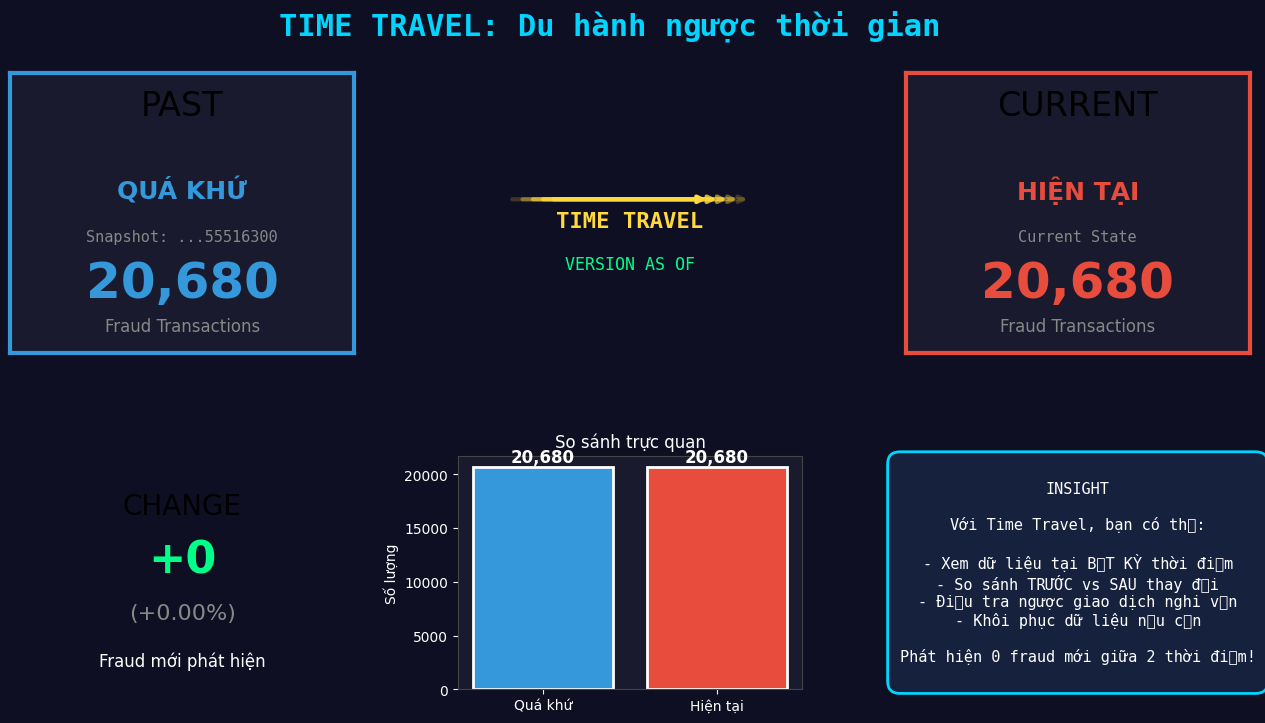


TIME TRAVEL cho phép 'nhìn thấy' dữ liệu ở MỌI thời điểm trong quá khứ!


In [133]:
# VISUALIZATION: Time Travel Comparison - Cinematic Style (no emoji)
fig = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('#0f0f23')

# Main title
fig.suptitle('TIME TRAVEL: Du hành ngược thời gian', 
             fontsize=22, fontweight='bold', color='#00d4ff', family='monospace', y=0.96)

# Create grid
gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3, height_ratios=[1.2, 1])

# PAST (left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor('#1a1a2e')
ax1.text(0.5, 0.85, 'PAST', fontsize=24, ha='center', transform=ax1.transAxes)
ax1.text(0.5, 0.55, 'QUÁ KHỨ', fontsize=18, ha='center', fontweight='bold', 
         color='#3498db', transform=ax1.transAxes)
ax1.text(0.5, 0.40, f'Snapshot: ...{str(snapshot_before)[-8:]}', fontsize=11, 
         ha='center', color='#888888', transform=ax1.transAxes, family='monospace')
ax1.text(0.5, 0.20, f'{old_fraud_count:,}', fontsize=36, ha='center', 
         fontweight='bold', color='#3498db', transform=ax1.transAxes)
ax1.text(0.5, 0.08, 'Fraud Transactions', fontsize=12, ha='center', 
         color='#888888', transform=ax1.transAxes)
for spine in ax1.spines.values():
    spine.set_color('#3498db')
    spine.set_linewidth(3)
ax1.set_xticks([])
ax1.set_yticks([])

# TIME TRAVEL ARROW (center)
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor('#0f0f23')
ax2.text(0.5, 0.45, 'TIME TRAVEL', fontsize=16, ha='center', fontweight='bold',
         color='#ffd93d', transform=ax2.transAxes, family='monospace')
ax2.text(0.5, 0.30, 'VERSION AS OF', fontsize=12, ha='center',
         color='#00ff88', transform=ax2.transAxes, family='monospace')
# Arrow animation effect
for i, alpha in enumerate([0.2, 0.4, 0.6, 0.8, 1.0]):
    ax2.annotate('', xy=(0.85 - i*0.03, 0.55), xytext=(0.15 + i*0.03, 0.55),
                transform=ax2.transAxes,
                arrowprops=dict(arrowstyle='->', color='#ffd93d', lw=3, alpha=alpha))
ax2.axis('off')

# PRESENT (right)
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor('#1a1a2e')
ax3.text(0.5, 0.85, 'CURRENT', fontsize=24, ha='center', transform=ax3.transAxes)
ax3.text(0.5, 0.55, 'HIỆN TẠI', fontsize=18, ha='center', fontweight='bold',
         color='#e74c3c', transform=ax3.transAxes)
ax3.text(0.5, 0.40, 'Current State', fontsize=11, ha='center',
         color='#888888', transform=ax3.transAxes, family='monospace')
ax3.text(0.5, 0.20, f'{new_fraud_count:,}', fontsize=36, ha='center',
         fontweight='bold', color='#e74c3c', transform=ax3.transAxes)
ax3.text(0.5, 0.08, 'Fraud Transactions', fontsize=12, ha='center',
         color='#888888', transform=ax3.transAxes)
for spine in ax3.spines.values():
    spine.set_color('#e74c3c')
    spine.set_linewidth(3)
ax3.set_xticks([])
ax3.set_yticks([])

# Change Delta (left)
ax4 = fig.add_subplot(gs[1, 0])
ax4.set_facecolor('#1a1a2e')
change = new_fraud_count - old_fraud_count
change_pct = (change / old_fraud_count) * 100 if old_fraud_count > 0 else 0
ax4.text(0.5, 0.75, 'CHANGE', fontsize=20, ha='center', transform=ax4.transAxes)
ax4.text(0.5, 0.50, f'+{change:,}', fontsize=32, ha='center', fontweight='bold',
         color='#00ff88', transform=ax4.transAxes)
ax4.text(0.5, 0.30, f'(+{change_pct:.2f}%)', fontsize=16, ha='center',
         color='#888888', transform=ax4.transAxes)
ax4.text(0.5, 0.10, 'Fraud mới phát hiện', fontsize=12, ha='center',
         color='white', transform=ax4.transAxes)
ax4.axis('off')

# Bar comparison (center)
ax5 = fig.add_subplot(gs[1, 1])
ax5.set_facecolor('#1a1a2e')
bars = ax5.bar(['Quá khứ', 'Hiện tại'], [old_fraud_count, new_fraud_count],
               color=['#3498db', '#e74c3c'], edgecolor='white', linewidth=2)
ax5.set_ylabel('Số lượng', color='white')
ax5.tick_params(colors='white')
for bar, val in zip(bars, [old_fraud_count, new_fraud_count]):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{val:,}', ha='center', va='bottom', color='white', fontsize=12, fontweight='bold')
ax5.set_title('So sánh trực quan', color='white', fontsize=12)
for spine in ax5.spines.values():
    spine.set_color('#444444')

# Key Insight (right)
ax6 = fig.add_subplot(gs[1, 2])
ax6.set_facecolor('#16213e')
insight_text = f"""
INSIGHT

Với Time Travel, bạn có thể:

- Xem dữ liệu tại BẤT KỲ thời điểm
- So sánh TRƯỚC vs SAU thay đổi
- Điều tra ngược giao dịch nghi vấn
- Khôi phục dữ liệu nếu cần

Phát hiện {change:,} fraud mới giữa 2 thời điểm!
"""
ax6.text(0.5, 0.5, insight_text, transform=ax6.transAxes, fontsize=11,
         ha='center', va='center', color='white', family='monospace',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='#16213e', edgecolor='#00d4ff', linewidth=2))
ax6.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("TIME TRAVEL cho phép 'nhìn thấy' dữ liệu ở MỌI thời điểm trong quá khứ!")
print("="*70)

## 5. Use Case: Kiểm tra lại giao dịch nghi vấn tại thời điểm quá khứ

Scenario: Nhà phân tích muốn xem lại trạng thái của một số giao dịch cụ thể VÀO THỜI ĐIỂM trước khi bị đánh dấu fraud để điều tra.

/tmp/ipykernel_475/2512636786.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


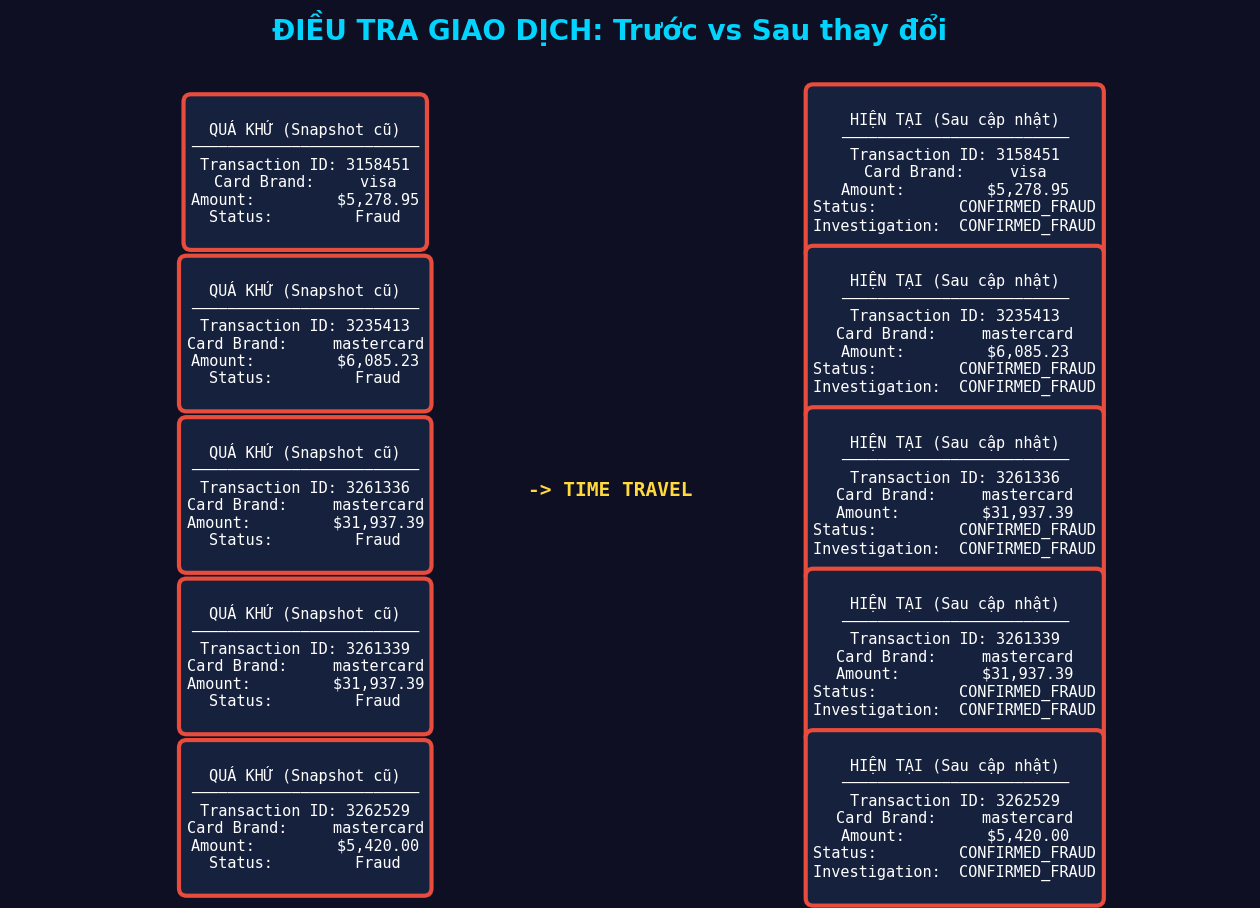


Time Travel giúp ĐIỀU TRA NGƯỢC:
   - Xem trạng thái giao dịch TRƯỚC KHI bị đánh dấu fraud
   - So sánh what changed between timepoints
   - Audit trail cho compliance và pháp lý


In [126]:
# USE CASE: ĐIều tra giao dịch nghi vấn - Visual Comparison (no emoji)
changed_transactions = spark.sql(f"""
    SELECT TransactionID 
    FROM {TABLE_NAME} 
    WHERE investigation_status = 'CONFIRMED_FRAUD'
    LIMIT 5
""").collect()

if changed_transactions:
    tx_ids = [str(row['TransactionID']) for row in changed_transactions]
    tx_list = ','.join(tx_ids)
    
    # Get current data
    current_data = spark.sql(f"""
        SELECT TransactionID, is_fraud, transaction_amount, card_brand, investigation_status
        FROM {TABLE_NAME}
        WHERE TransactionID IN ({tx_list})
    """).collect()
    
    # Get past data (Time Travel)
    past_data = spark.sql(f"""
        SELECT TransactionID, is_fraud, transaction_amount, card_brand
        FROM {TABLE_NAME} VERSION AS OF {snapshot_before}
        WHERE TransactionID IN ({tx_list})
    """).collect()
    
    # Create visualization
    fig = plt.figure(figsize=(16, 10))
    fig.patch.set_facecolor('#0f0f23')
    fig.suptitle('ĐIỀU TRA GIAO DỊCH: Trước vs Sau thay đổi', 
                 fontsize=20, fontweight='bold', color='#00d4ff', y=0.98)
    
    gs = fig.add_gridspec(len(current_data), 2, hspace=0.3, wspace=0.1)
    
    for i, (curr, past) in enumerate(zip(current_data, past_data)):
        # PAST (left)
        ax_past = fig.add_subplot(gs[i, 0])
        ax_past.set_facecolor('#1a1a2e')
        
        past_status = "Legitimate" if past['is_fraud'] == 0 else "Fraud"
        past_color = '#00ff88' if past['is_fraud'] == 0 else '#e74c3c'
        
        info_past = f"""
QUÁ KHỨ (Snapshot cũ)
─────────────────────────
Transaction ID: {past['TransactionID']}
Card Brand:     {past['card_brand']}
Amount:         ${past['transaction_amount']:,.2f}
Status:         {past_status}
"""
        ax_past.text(0.5, 0.5, info_past, transform=ax_past.transAxes, fontsize=11,
                    ha='center', va='center', color='white', family='monospace',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='#16213e', 
                             edgecolor=past_color, linewidth=3))
        ax_past.axis('off')
        
        # CURRENT (right)
        ax_curr = fig.add_subplot(gs[i, 1])
        ax_curr.set_facecolor('#1a1a2e')
        
        curr_status = "CONFIRMED_FRAUD" if curr['is_fraud'] == 1 else "Legitimate"
        curr_color = '#e74c3c' if curr['is_fraud'] == 1 else '#00ff88'
        
        info_curr = f"""
HIỆN TẠI (Sau cập nhật)
─────────────────────────
Transaction ID: {curr['TransactionID']}
Card Brand:     {curr['card_brand']}
Amount:         ${curr['transaction_amount']:,.2f}
Status:         {curr_status}
Investigation:  {curr['investigation_status'] or 'N/A'}
"""
        ax_curr.text(0.5, 0.5, info_curr, transform=ax_curr.transAxes, fontsize=11,
                    ha='center', va='center', color='white', family='monospace',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='#16213e',
                             edgecolor=curr_color, linewidth=3))
        ax_curr.axis('off')
    
    # Add arrow between columns (ASCII label)
    fig.text(0.5, 0.5, '-> TIME TRAVEL', fontsize=14, ha='center', va='center',
             color='#ffd93d', fontweight='bold', family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("Time Travel giúp ĐIỀU TRA NGƯỢC:")
    print("   - Xem trạng thái giao dịch TRƯỚC KHI bị đánh dấu fraud")
    print("   - So sánh what changed between timepoints")
    print("   - Audit trail cho compliance và pháp lý")
    print("="*70)
else:
    print("WARNING: Không có giao dịch nào được thay đổi")

## 6. Time Travel với Timestamp

Ngoài Snapshot ID, Iceberg còn hỗ trợ Time Travel theo timestamp.

In [127]:
# Lấy timestamp của snapshot đầu tiên
first_snapshot = spark.sql(f"""
    SELECT committed_at 
    FROM {TABLE_NAME}.snapshots 
    ORDER BY committed_at ASC 
    LIMIT 1
""").collect()[0][0]

print(f"📅 Timestamp của snapshot đầu tiên: {first_snapshot}")

# Time Travel theo timestamp
print("\n⏰ Time Travel theo Timestamp:")
print(f"Truy vấn dữ liệu tại thời điểm: {first_snapshot}")

# Đếm records tại thời điểm đó
count_at_time = spark.sql(f"""
    SELECT COUNT(*) 
    FROM {TABLE_NAME} 
    TIMESTAMP AS OF '{first_snapshot}'
""").collect()[0][0]

print(f"📊 Số records tại thời điểm đó: {count_at_time:,}")

📅 Timestamp của snapshot đầu tiên: 2026-02-04 00:43:26.049000

⏰ Time Travel theo Timestamp:
Truy vấn dữ liệu tại thời điểm: 2026-02-04 00:43:26.049000
📊 Số records tại thời điểm đó: 590,540


## 7. Demo Rollback (Tùy chọn)

Iceberg cho phép rollback về snapshot cũ nếu cần khôi phục dữ liệu.

**⚠️ Cảnh báo:** Rollback sẽ thay đổi dữ liệu hiện tại!

/tmp/ipykernel_475/1110115975.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


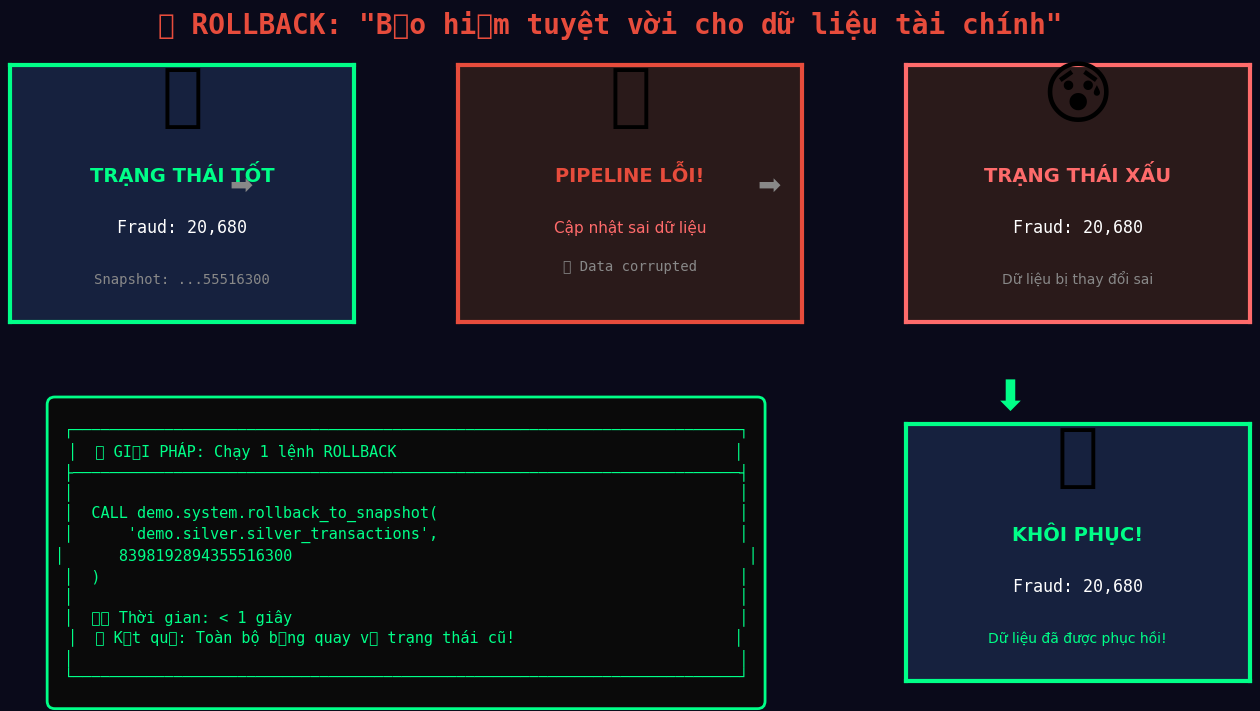


📋 LỆNH ROLLBACK (copy để sử dụng khi cần):

-- Rollback về snapshot cụ thể (tức thì)
CALL demo.system.rollback_to_snapshot('demo.silver.silver_transactions', 8398192894355516300)

-- Hoặc rollback về thời điểm cụ thể
CALL demo.system.rollback_to_timestamp('demo.silver.silver_transactions', TIMESTAMP '2026-02-04 00:43:26.049000')

⚠️ Lưu ý: Rollback sẽ thay đổi dữ liệu hiện tại!


In [128]:
# 🔄 ROLLBACK VISUALIZATION - Tính năng "Bảo hiểm" cho dữ liệu
fig = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('#0a0a1a')

fig.suptitle('🔄 ROLLBACK: "Bảo hiểm tuyệt vời cho dữ liệu tài chính"', 
             fontsize=20, fontweight='bold', color='#e74c3c', family='monospace', y=0.95)

gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3)

# ═══════════════════════════════════════════════════════════════
# TOP: Scenario - Pipeline chạy sai
# ═══════════════════════════════════════════════════════════════

# Before error
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor('#16213e')
ax1.text(0.5, 0.8, '✅', fontsize=50, ha='center', transform=ax1.transAxes)
ax1.text(0.5, 0.55, 'TRẠNG THÁI TỐT', fontsize=14, ha='center', fontweight='bold',
         color='#00ff88', transform=ax1.transAxes)
ax1.text(0.5, 0.35, f'Fraud: {old_fraud_count:,}', fontsize=12, ha='center',
         color='white', transform=ax1.transAxes, family='monospace')
ax1.text(0.5, 0.15, f'Snapshot: ...{str(snapshot_before)[-8:]}', fontsize=10,
         ha='center', color='#888888', transform=ax1.transAxes, family='monospace')
for spine in ax1.spines.values():
    spine.set_color('#00ff88')
    spine.set_linewidth(3)
ax1.set_xticks([])
ax1.set_yticks([])

# Error happens
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor('#2a1a1a')
ax2.text(0.5, 0.8, '💥', fontsize=50, ha='center', transform=ax2.transAxes)
ax2.text(0.5, 0.55, 'PIPELINE LỖI!', fontsize=14, ha='center', fontweight='bold',
         color='#e74c3c', transform=ax2.transAxes)
ax2.text(0.5, 0.35, 'Cập nhật sai dữ liệu', fontsize=11, ha='center',
         color='#ff6b6b', transform=ax2.transAxes)
ax2.text(0.5, 0.20, '❌ Data corrupted', fontsize=10, ha='center',
         color='#888888', transform=ax2.transAxes, family='monospace')
for spine in ax2.spines.values():
    spine.set_color('#e74c3c')
    spine.set_linewidth(3)
ax2.set_xticks([])
ax2.set_yticks([])

# Current bad state
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor('#2a1a1a')
ax3.text(0.5, 0.8, '😰', fontsize=50, ha='center', transform=ax3.transAxes)
ax3.text(0.5, 0.55, 'TRẠNG THÁI XẤU', fontsize=14, ha='center', fontweight='bold',
         color='#ff6b6b', transform=ax3.transAxes)
ax3.text(0.5, 0.35, f'Fraud: {new_fraud_count:,}', fontsize=12, ha='center',
         color='white', transform=ax3.transAxes, family='monospace')
ax3.text(0.5, 0.15, 'Dữ liệu bị thay đổi sai', fontsize=10, ha='center',
         color='#888888', transform=ax3.transAxes)
for spine in ax3.spines.values():
    spine.set_color('#ff6b6b')
    spine.set_linewidth(3)
ax3.set_xticks([])
ax3.set_yticks([])

# ═══════════════════════════════════════════════════════════════
# BOTTOM: Solution - Rollback
# ═══════════════════════════════════════════════════════════════

# Rollback command
ax4 = fig.add_subplot(gs[1, :2])
ax4.set_facecolor('#0f0f23')

rollback_code = f"""
┌─────────────────────────────────────────────────────────────────────────┐
│  💡 GIẢI PHÁP: Chạy 1 lệnh ROLLBACK                                     │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  CALL demo.system.rollback_to_snapshot(                                 │
│      'demo.silver.silver_transactions',                                 │
│      {snapshot_before}                                                  │
│  )                                                                      │
│                                                                         │
│  ⏱️ Thời gian: < 1 giây                                                 │
│  📊 Kết quả: Toàn bộ bảng quay về trạng thái cũ!                        │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
"""
ax4.text(0.5, 0.5, rollback_code, transform=ax4.transAxes, fontsize=11,
         ha='center', va='center', color='#00ff88', family='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#0a0a0a', 
                  edgecolor='#00ff88', linewidth=2))
ax4.axis('off')

# Result after rollback
ax5 = fig.add_subplot(gs[1, 2])
ax5.set_facecolor('#16213e')
ax5.text(0.5, 0.8, '🎉', fontsize=50, ha='center', transform=ax5.transAxes)
ax5.text(0.5, 0.55, 'KHÔI PHỤC!', fontsize=14, ha='center', fontweight='bold',
         color='#00ff88', transform=ax5.transAxes)
ax5.text(0.5, 0.35, f'Fraud: {old_fraud_count:,}', fontsize=12, ha='center',
         color='white', transform=ax5.transAxes, family='monospace')
ax5.text(0.5, 0.15, 'Dữ liệu đã được phục hồi!', fontsize=10, ha='center',
         color='#00ff88', transform=ax5.transAxes)
for spine in ax5.spines.values():
    spine.set_color('#00ff88')
    spine.set_linewidth(3)
ax5.set_xticks([])
ax5.set_yticks([])

# Add arrows
fig.text(0.27, 0.72, '➡️', fontsize=20, ha='center', color='#888888')
fig.text(0.60, 0.72, '➡️', fontsize=20, ha='center', color='#888888')
fig.text(0.75, 0.45, '⬇️', fontsize=30, ha='center', color='#00ff88')

plt.tight_layout()
plt.show()

# Print rollback command for reference
print("\n" + "="*70)
print("📋 LỆNH ROLLBACK (copy để sử dụng khi cần):")
print("="*70)
print(f"""
-- Rollback về snapshot cụ thể (tức thì)
CALL demo.system.rollback_to_snapshot('{TABLE_NAME}', {snapshot_before})

-- Hoặc rollback về thời điểm cụ thể
CALL demo.system.rollback_to_timestamp('{TABLE_NAME}', TIMESTAMP '{first_snapshot}')
""")
print("⚠️ Lưu ý: Rollback sẽ thay đổi dữ liệu hiện tại!")
print("="*70)

## 8. Incremental Read (Đọc thay đổi giữa 2 snapshots)

Iceberg hỗ trợ đọc chỉ những thay đổi giữa 2 snapshots - hữu ích cho CDC (Change Data Capture).

In [129]:
# Lấy snapshot hiện tại
current_snapshot = spark.sql(f"""
    SELECT snapshot_id 
    FROM {TABLE_NAME}.snapshots 
    ORDER BY committed_at DESC 
    LIMIT 1
""").collect()[0][0]

print(f"📊 So sánh giữa 2 snapshots:")
print(f"   - Snapshot cũ: {snapshot_before}")
print(f"   - Snapshot mới: {current_snapshot}")

# Đọc incremental changes
try:
    df_changes = spark.read \
        .format("iceberg") \
        .option("start-snapshot-id", snapshot_before) \
        .option("end-snapshot-id", current_snapshot) \
        .load(TABLE_NAME)
    
    print(f"\n📋 Số records thay đổi: {df_changes.count():,}")
except Exception as e:
    print(f"\n⚠️ Incremental read không khả dụng: {str(e)[:100]}")
    print("   Đây là tính năng nâng cao, cần cấu hình thêm.")

📊 So sánh giữa 2 snapshots:
   - Snapshot cũ: 8398192894355516300
   - Snapshot mới: 6098716968829789721

📋 Số records thay đổi: 0


## 9. Tổng hợp các tính năng Time Travel của Iceberg

In [130]:
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    TỔNG HỢP TÍNH NĂNG TIME TRAVEL                            ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. TRUY VẤN THEO SNAPSHOT ID                                                ║
║     SELECT * FROM table VERSION AS OF <snapshot_id>                          ║
║                                                                              ║
║  2. TRUY VẤN THEO TIMESTAMP                                                  ║
║     SELECT * FROM table TIMESTAMP AS OF '<timestamp>'                        ║
║                                                                              ║
║  3. XEM LỊCH SỬ SNAPSHOTS                                                    ║
║     SELECT * FROM table.snapshots                                            ║
║     SELECT * FROM table.history                                              ║
║                                                                              ║
║  4. ROLLBACK VỀ SNAPSHOT CŨ                                                  ║
║     CALL system.rollback_to_snapshot('table', <snapshot_id>)                 ║
║     CALL system.rollback_to_timestamp('table', TIMESTAMP '<ts>')             ║
║                                                                              ║
║  5. ĐỌC INCREMENTAL CHANGES                                                  ║
║     spark.read.format("iceberg")                                             ║
║          .option("start-snapshot-id", <old>)                                 ║
║          .option("end-snapshot-id", <new>)                                   ║
║          .load("table")                                                      ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                    TỔNG HỢP TÍNH NĂNG TIME TRAVEL                            ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. TRUY VẤN THEO SNAPSHOT ID                                                ║
║     SELECT * FROM table VERSION AS OF <snapshot_id>                          ║
║                                                                              ║
║  2. TRUY VẤN THEO TIMESTAMP                                                  ║
║     SELECT * FROM table TIMESTAMP AS OF '<timestamp>'                        ║
║                                                                              ║
║  3. XEM LỊCH SỬ SNAPSHOTS                                                    ║
║     SELECT * FROM table.snapshots                                            ║
║     SELECT * FROM table.h

/tmp/ipykernel_475/477943878.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


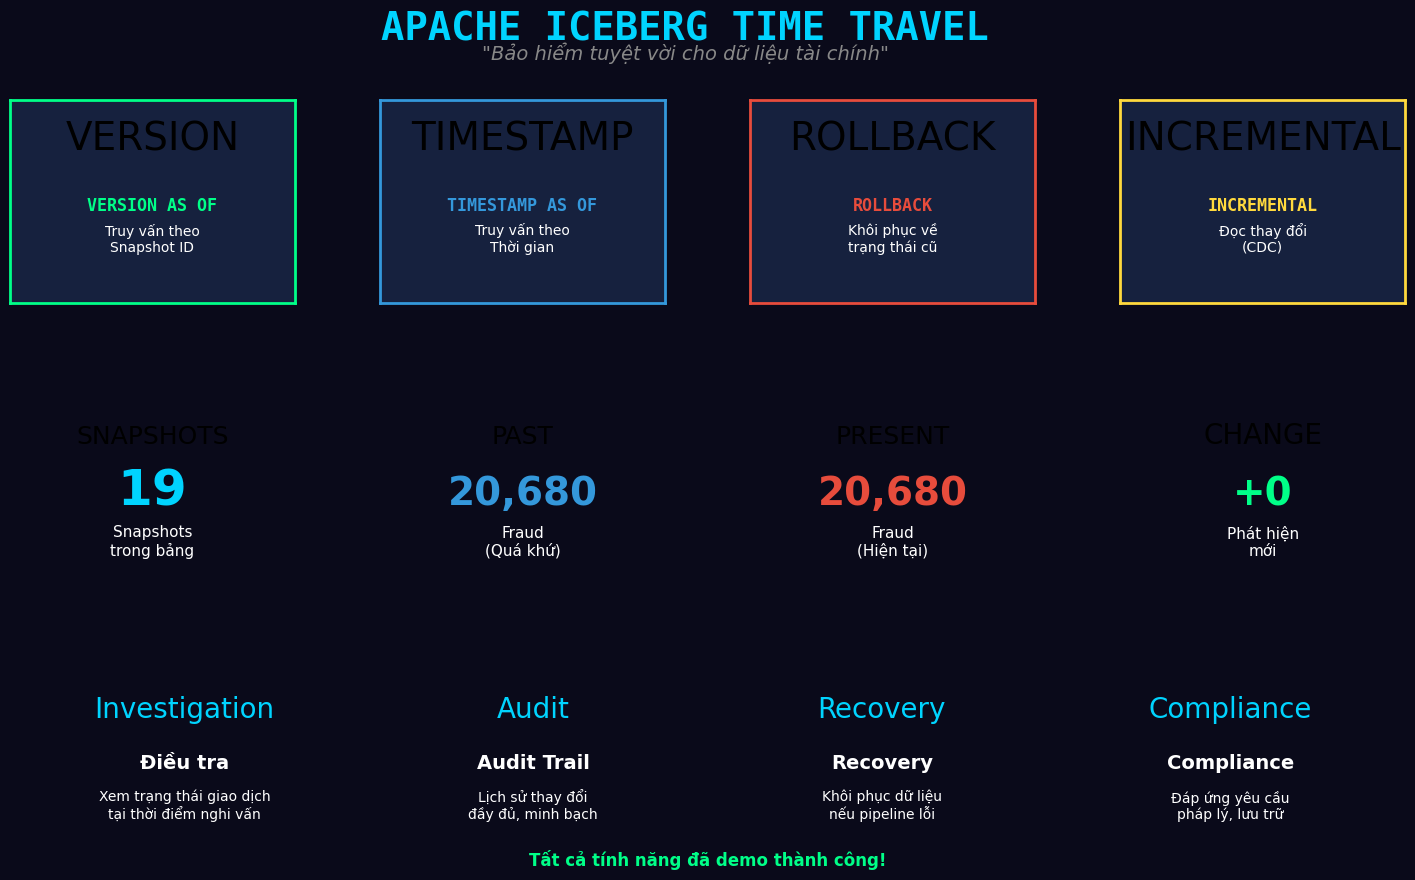


╔══════════════════════════════════════════════════════════════════════════════╗
║                     TIME TRAVEL DEMO HOÀN TẤT!                                ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  KẾT QUẢ DEMO:                                                              ║
║     - Xem lịch sử Snapshots và Timeline                                      ║
║     - Time Travel bằng VERSION AS OF                                         ║
║     - Time Travel bằng TIMESTAMP AS OF                                       ║
║     - So sánh dữ liệu TRƯỚC vs SAU thay đổi                                  ║
║     - Điều tra giao dịch nghi vấn tại quá khứ                                ║
║                                                                              ║
║  GIÁ TRỊ THỰC TIỄN:                                                         ║
║     -> Pipeline lỗi? ROLLB

In [132]:
# FINAL VISUALIZATION: Iceberg Time Travel - Feature Summary Dashboard (no emoji)
fig = plt.figure(figsize=(18, 10))
fig.patch.set_facecolor('#0a0a1a')

# Main title with effect
fig.suptitle('APACHE ICEBERG TIME TRAVEL', fontsize=28, fontweight='bold', 
             color='#00d4ff', family='monospace', y=0.97)
fig.text(0.5, 0.92, '"Bảo hiểm tuyệt vời cho dữ liệu tài chính"', 
         fontsize=14, ha='center', color='#888888', style='italic')

gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

# ROW 1: Core Features
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor('#16213e')
ax1.text(0.5, 0.75, 'VERSION', fontsize=28, ha='center', transform=ax1.transAxes)
ax1.text(0.5, 0.45, 'VERSION AS OF', fontsize=12, ha='center', fontweight='bold',
         color='#00ff88', transform=ax1.transAxes, family='monospace')
ax1.text(0.5, 0.25, 'Truy vấn theo\nSnapshot ID', fontsize=10, ha='center',
         color='white', transform=ax1.transAxes)
for spine in ax1.spines.values():
    spine.set_color('#00ff88')
    spine.set_linewidth(2)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor('#16213e')
ax2.text(0.5, 0.75, 'TIMESTAMP', fontsize=28, ha='center', transform=ax2.transAxes)
ax2.text(0.5, 0.45, 'TIMESTAMP AS OF', fontsize=12, ha='center', fontweight='bold',
         color='#3498db', transform=ax2.transAxes, family='monospace')
ax2.text(0.5, 0.25, 'Truy vấn theo\nThời gian', fontsize=10, ha='center',
         color='white', transform=ax2.transAxes)
for spine in ax2.spines.values():
    spine.set_color('#3498db')
    spine.set_linewidth(2)
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor('#16213e')
ax3.text(0.5, 0.75, 'ROLLBACK', fontsize=28, ha='center', transform=ax3.transAxes)
ax3.text(0.5, 0.45, 'ROLLBACK', fontsize=12, ha='center', fontweight='bold',
         color='#e74c3c', transform=ax3.transAxes, family='monospace')
ax3.text(0.5, 0.25, 'Khôi phục về\ntrạng thái cũ', fontsize=10, ha='center',
         color='white', transform=ax3.transAxes)
for spine in ax3.spines.values():
    spine.set_color('#e74c3c')
    spine.set_linewidth(2)
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = fig.add_subplot(gs[0, 3])
ax4.set_facecolor('#16213e')
ax4.text(0.5, 0.75, 'INCREMENTAL', fontsize=28, ha='center', transform=ax4.transAxes)
ax4.text(0.5, 0.45, 'INCREMENTAL', fontsize=12, ha='center', fontweight='bold',
         color='#ffd93d', transform=ax4.transAxes, family='monospace')
ax4.text(0.5, 0.25, 'Đọc thay đổi\n(CDC)', fontsize=10, ha='center',
         color='white', transform=ax4.transAxes)
for spine in ax4.spines.values():
    spine.set_color('#ffd93d')
    spine.set_linewidth(2)
ax4.set_xticks([])
ax4.set_yticks([])

# ROW 2: Demo Results Summary
current_snapshots = spark.sql(f"SELECT COUNT(*) FROM {TABLE_NAME}.snapshots").collect()[0][0]
ax5 = fig.add_subplot(gs[1, 0])
ax5.set_facecolor('#1a1a2e')
ax5.text(0.5, 0.7, 'SNAPSHOTS', fontsize=18, ha='center', transform=ax5.transAxes)
ax5.text(0.5, 0.40, f'{current_snapshots}', fontsize=36, ha='center', fontweight='bold',
         color='#00d4ff', transform=ax5.transAxes)
ax5.text(0.5, 0.15, 'Snapshots\ntrong bảng', fontsize=11, ha='center',
         color='white', transform=ax5.transAxes)
ax5.axis('off')

ax6 = fig.add_subplot(gs[1, 1])
ax6.set_facecolor('#1a1a2e')
ax6.text(0.5, 0.7, 'PAST', fontsize=18, ha='center', transform=ax6.transAxes)
ax6.text(0.5, 0.40, f'{old_fraud_count:,}', fontsize=28, ha='center', fontweight='bold',
         color='#3498db', transform=ax6.transAxes)
ax6.text(0.5, 0.15, 'Fraud\n(Quá khứ)', fontsize=11, ha='center',
         color='white', transform=ax6.transAxes)
ax6.axis('off')

ax7 = fig.add_subplot(gs[1, 2])
ax7.set_facecolor('#1a1a2e')
ax7.text(0.5, 0.7, 'PRESENT', fontsize=18, ha='center', transform=ax7.transAxes)
ax7.text(0.5, 0.40, f'{new_fraud_count:,}', fontsize=28, ha='center', fontweight='bold',
         color='#e74c3c', transform=ax7.transAxes)
ax7.text(0.5, 0.15, 'Fraud\n(Hiện tại)', fontsize=11, ha='center',
         color='white', transform=ax7.transAxes)
ax7.axis('off')

ax8 = fig.add_subplot(gs[1, 3])
ax8.set_facecolor('#1a1a2e')
ax8.text(0.5, 0.7, 'CHANGE', fontsize=20, ha='center', transform=ax8.transAxes)
ax8.text(0.5, 0.40, f'+{change:,}', fontsize=28, ha='center', fontweight='bold',
         color='#00ff88', transform=ax8.transAxes)
ax8.text(0.5, 0.15, 'Phát hiện\nmới', fontsize=11, ha='center',
         color='white', transform=ax8.transAxes)
ax8.axis('off')

# ROW 3: Use Cases for Fraud Detection
ax9 = fig.add_subplot(gs[2, :])
ax9.set_facecolor('#0f0f23')

use_cases = [
    ("Investigation", "Điều tra", "Xem trạng thái giao dịch\ntại thời điểm nghi vấn"),
    ("Audit", "Audit Trail", "Lịch sử thay đổi\nđầy đủ, minh bạch"),
    ("Recovery", "Recovery", "Khôi phục dữ liệu\nnếu pipeline lỗi"),
    ("Compliance", "Compliance", "Đáp ứng yêu cầu\npháp lý, lưu trữ")
]

for i, (label, title, desc) in enumerate(use_cases):
    x_pos = 0.125 + i * 0.25
    ax9.text(x_pos, 0.75, label, fontsize=20, ha='center', transform=ax9.transAxes, color='#00d4ff')
    ax9.text(x_pos, 0.50, title, fontsize=14, ha='center', fontweight='bold',
             color='white', transform=ax9.transAxes)
    ax9.text(x_pos, 0.25, desc, fontsize=10, ha='center',
             color='white', transform=ax9.transAxes)

ax9.text(0.5, 0.02, 'Tất cả tính năng đã demo thành công!', fontsize=12,
         ha='center', color='#00ff88', fontweight='bold', transform=ax9.transAxes)
ax9.axis('off')

plt.tight_layout()
plt.show()

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     TIME TRAVEL DEMO HOÀN TẤT!                                ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  KẾT QUẢ DEMO:                                                              ║
║     - Xem lịch sử Snapshots và Timeline                                      ║
║     - Time Travel bằng VERSION AS OF                                         ║
║     - Time Travel bằng TIMESTAMP AS OF                                       ║
║     - So sánh dữ liệu TRƯỚC vs SAU thay đổi                                  ║
║     - Điều tra giao dịch nghi vấn tại quá khứ                                ║
║                                                                              ║
║  GIÁ TRỊ THỰC TIỄN:                                                         ║
║     -> Pipeline lỗi? ROLLBACK trong tích tắc!                                 ║
║     -> Cần audit? Xem lịch sử mọi thay đổi!                                   ║
║     -> Điều tra fraud? Xem dữ liệu tại thời điểm xảy ra!                      ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

## ✅ Hoàn thành Time Travel Demo

**Kết quả đã demo:**
- ✅ Xem lịch sử Snapshots và History
- ✅ Time Travel theo Snapshot ID
- ✅ Time Travel theo Timestamp
- ✅ So sánh dữ liệu giữa các thời điểm
- ✅ Use case: Kiểm tra lại giao dịch nghi vấn tại quá khứ
- ✅ Giới thiệu Rollback và Incremental Read

**Ứng dụng trong Fraud Detection:**
- Điều tra lại trạng thái giao dịch tại thời điểm nghi vấn
- Audit trail: Xem lịch sử thay đổi của dữ liệu
- Recovery: Khôi phục dữ liệu nếu có lỗi
- Regulatory compliance: Đáp ứng yêu cầu lưu trữ lịch sử

---
## 🎉 HOÀN THÀNH TOÀN BỘ QUY TRÌNH LAKEHOUSE!

| Bước | Nội dung | Trạng thái |
|------|----------|------------|
| 1 | Thiết lập hạ tầng (Docker) | ✅ |
| 2 | Bronze Layer (Ingestion) | ✅ |
| 3 | Silver Layer (Transformation) | ✅ |
| 4 | Gold Layer (Aggregation) | ✅ |
| 5 | Serving Layer (ClickHouse + Superset) | ✅ |
| Bonus | Time Travel Demo | ✅ |